## Time Series Forecasting with CNN, LSTM, CNN+LSTM

data: kaggle corn2013-2017.txt

In [11]:
import pandas as pd
from pandas import Series

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import TimeDistributed


In [2]:
# Df from 14/04/2015 to 14/04/2019
df = pd.read_csv("corn2013-2017.txt", header = None)
df.columns = ['Date', 'Corn price']
df.head()

,Date,Corn price
0,2013-01-06,7.794975
1,2013-01-13,7.863400
2,2013-01-20,8.234920
3,2013-01-27,8.186260
4,2013-02-03,8.317480


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(10)

,Corn price
Date,
2013-01-06,7.794975
2013-01-13,7.863400
2013-01-20,8.234920
2013-01-27,8.186260
2013-02-03,8.317480
2013-02-10,8.154040
2013-02-17,7.883740
2013-02-24,7.859420
2013-03-03,7.958560


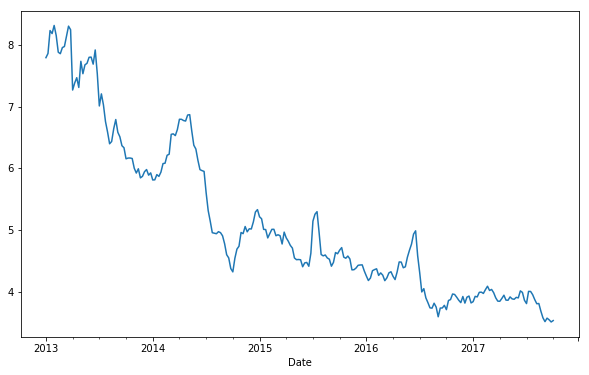

In [4]:
# Visualize Adj Close by date
plt.figure(figsize=(10, 6))
df['Corn price'].plot();

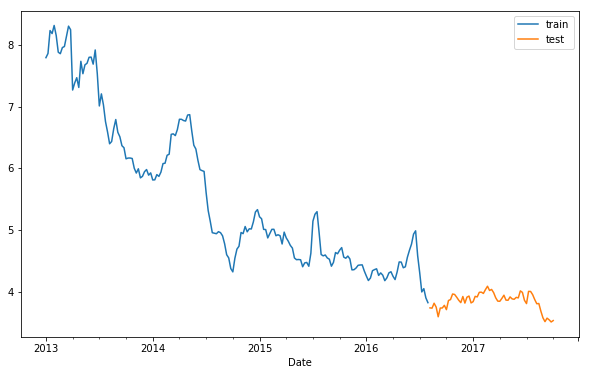

In [5]:
# For the model split data fro trainig and testing that will be used to check the prediction
split_date = pd.Timestamp('2016-08-01')
df =  df['Corn price']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [6]:
# Explore data
print('Train type: ', type(train))
print('First element: ', train[0])
print('The lenght: ', len(train))

print('Test type: ', type(test))
print('First element: ', test[0])
print('The lenght: ', len(test))

Train type:  <class 'pandas.core.series.Series'>
First element:  7.794975
The lenght:  187
Test type:  <class 'pandas.core.series.Series'>
First element:  3.73564
The lenght:  61


In [7]:
# Normilize train and test data

train = train.values
train = train.reshape((len(train), 1))

test = test.values
test = test.reshape((len(test), 1))

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

Min: 3.820160, Max: 8.317480


In [8]:
train_normalized = scaler.transform(train)
test_normalized = scaler.transform(test)

In [9]:
print('Train normalized: ', train_normalized[:5])
print('Test normalized: ', test_normalized[:5])

Train normalized:  [[0.88381859]
 [0.8990332 ]
 [0.9816424 ]
 [0.97082262]
 [1.        ]]
Test normalized:  [[-0.01879341]
 [-0.01978067]
 [-0.0019923 ]
 [-0.01580497]
 [-0.05089698]]


In [10]:
# Get train and test for the model
X_train = train_normalized[:-1]
y_train = train_normalized[1:]

X_test = test_normalized[:-1]
y_test = test_normalized[1:]

In [40]:
# reate new X_train/test and y_train/test vectors
def convert_to_Xy_1d(data, feature_idx, n_input=7, n_output=1):
    X, y = [],[]
    in_start = 0
    for i in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_output
        if out_end < len(data):
            x_input = data[in_start:in_end, feature_idx]
            x_input = x_input.reshape((len(x_input), 1)) # column vector
            X.append(x_input)
            y.append(data[in_end:out_end, feature_idx])
        # step forward one unit
        in_start += 1
    return np.array(X), np.array(y)

In [41]:
trainX, trainy = convert_to_Xy_1d(X_train, 0)

In [42]:
print(trainX[1].shape)
print(trainX[1])

(7, 1)
[[0.8990332 ]
 [0.9816424 ]
 [0.97082262]
 [1.        ]
 [0.96365836]
 [0.9035559 ]
 [0.89814823]]


In [43]:
print(trainy[1].shape)
print(trainy[1])

(1,)
[0.92019247]


In [44]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print(n_timesteps, n_features, n_outputs)

7 1 1


# CNN model

In [45]:
# Create model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=12, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features))) #same as trainX[0].shape 
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(n_outputs, activation='softmax'))
cnn_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = cnn_model.fit(trainX, trainy, epochs=100, batch_size=4, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
178/178 [==============================] - 2s 9ms/step - loss: 0.1864
Epoch 2/100
178/178 [==============================] - 0s 2ms/step - loss: 0.1864
Epoch 3/100
178/178 [==============================] - 0s 852us/step - loss: 0.1864
Epoch 4/100
178/178 [==============================] - 0s 844us/step - loss: 0.1864
Epoch 00004: early stopping


In [46]:
testX, testy = convert_to_Xy_1d(X_test, 0)

In [47]:
y_pred_test_nn = cnn_model.predict(testX)
y_train_pred_nn = cnn_model.predict(trainX)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(trainy, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(testy, y_pred_test_nn)))

The R2 score on the Train set is:	-6.305
The R2 score on the Test set is:	-1291.139


In [48]:
def convert_to_1darray(y):
    y_pred = []
    y_pred.extend(y[0])
    for i in range(1,len(y)):
        y_pred.append(y[i][0])
    
    return y_pred

In [49]:
y_pred_cnn = convert_to_1darray(y_pred_test_nn)

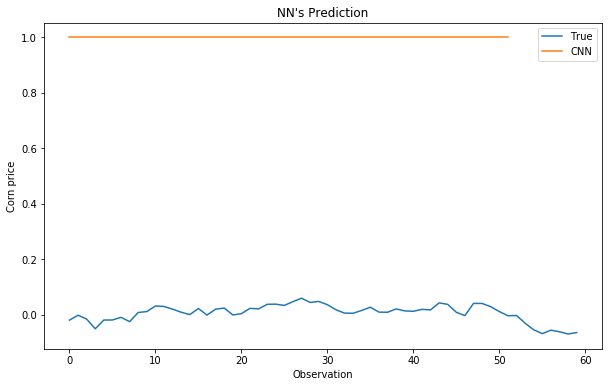

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_cnn, label='CNN')
plt.title("NN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Corn price')
plt.legend()
plt.show();